# Perform the main analysis for TCR-bert

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
import re
import torch
import tqdm
import pandas as pd
import tqdm 
from transformers import BertModel, BertTokenizer
import pandas as pd
import pickle as pkl
import datasets 
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel

import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, SVR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dfetr=pd.read_csv('./data/BAP/epi_split/train.csv', header=None)
dfete=pd.read_csv('./data/BAP/epi_split/test.csv', header=None)
dfetr.columns = ['Epitope', 'TCR', 'Label']
dfete.columns = ['Epitope', 'TCR', 'Label']

dfttr=pd.read_csv('./data/BAP/tcr_split/train.csv', header=None)
dftte=pd.read_csv('./data/BAP/tcr_split/test.csv', header=None)
dfttr.columns = ['Epitope', 'TCR', 'Label']
dftte.columns = ['Epitope', 'TCR', 'Label']


dfho_epi=pd.read_csv('./data/true_hold_out/epitope_split_test.csv', header=None)
dfho_tcr=pd.read_csv('./data/true_hold_out/tcr_split_test.csv', header=None)
dfho_epi.columns = ['Epitope', 'TCR'] 
dfho_tcr.columns = ['Epitope', 'TCR']

dfemb=pd.read_csv('./data/embedding/TCRrepertoires.csv', header=None)


In [150]:
def report_svm_results(embs_tr, y_tr, embs_te, y_te, clf_type='reg'):

    # Split data into train and test
    X_train, X_valid, y_train, y_valid = train_test_split(embs_tr, y_tr, test_size=0.2, random_state=42)

    X_test = embs_te
    y_test = y_te
    if 'logistic' in clf_type.lower():
        CLFMethod = LogisticRegression
    elif 'boost' in clf_type.lower():
        CLFMethod = GradientBoostingClassifier
    elif 'svm' in clf_type.lower():
        CLFMethod = SVC
        
    # Normalize -> PCA -> SVR Pipeline
    svr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('svr', CLFMethod())
    ])
    
    # Fit and predict
    print('Fitting Model...')
    svr_pipeline.fit(X_train, y_train)
    y_pred_svr = svr_pipeline.predict(X_valid)
    
    # Since SVR is a regressor, convert predictions to binary labels for classification metrics
    y_pred_svr_binary = (y_pred_svr > 0.5).astype(int)
    
    # Metrics for SVR
    val_accuracy_svr = accuracy_score(y_valid, y_pred_svr_binary)
    val_rocauc_svr = roc_auc_score(y_valid, y_pred_svr_binary)
    val_f1_svr = f1_score(y_valid, y_pred_svr_binary)
    val_prec_svr = precision_score(y_valid, y_pred_svr_binary)
    val_rec_svr = recall_score(y_valid, y_pred_svr_binary)

    print("=======================================================")
    print('VALIDATION Metrics')
    print("SVR Metrics: ")
    print(f"Accuracy: {val_accuracy_svr:.4f}")
    print(f"ROC AUC: {val_rocauc_svr:.4f}")
    print(f"F1 Score: {val_f1_svr:.4f}")
    print(f"Precision score: {val_prec_svr:.4f}")
    print(f"Recall score: {val_rec_svr:.4f}")

    y_pred_svr = svr_pipeline.predict(X_test)
    
    # Since SVR is a regressor, convert predictions to binary labels for classification metrics
    y_pred_svr_binary = (y_pred_svr > 0.5).astype(int)
    print(X_test.shape)
    print(y_test.shape)
    print(y_pred_svr_binary.shape)

    #Re-instantiate SVR pipeline - train on all the data for testing phase
    svr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('svr', CLFMethod())
    ])
    
    print('Fitting Model...')
    svr_pipeline.fit(embs_tr, y_tr)
    
    # Metrics for SVR
    accuracy_svr = accuracy_score(y_test, y_pred_svr_binary)
    rocauc_svr = roc_auc_score(y_test, y_pred_svr_binary)
    f1_svr = f1_score(y_test, y_pred_svr_binary)
    prec_svr = precision_score(y_test, y_pred_svr_binary)
    rec_svr = recall_score(y_test, y_pred_svr_binary)
    
    print("=======================================================")
    print('Test set Metrics')
    print(f"Accuracy: {accuracy_svr:.4f}")
    print(f"ROC AUC: {rocauc_svr:.4f}")
    print(f"F1 Score: {f1_svr:.4f}")
    print(f"Precision score: {prec_svr:.4f}")
    print(f"Recall score: {rec_svr:.4f}")

    return accuracy_svr, val_accuracy_svr, rocauc_svr, val_rocauc_svr, f1_svr, prec_svr, rec_svr


In [163]:
def run_emb_config(dct, dct_te, trlab, telab, prompt_method, embedding_agg_method, clf_type):
    if prompt_method=='joint':
        embstr = dct[f'joint_{embedding_agg_method}']
        embste = dct_te[f'joint_{embedding_agg_method}']
    else:
        embstr = np.concatenate((dct[f'epi_{embedding_agg_method}'], dct[f'tcr_{embedding_agg_method}']), axis=1)
        embste = np.concatenate((dct_te[f'epi_{embedding_agg_method}'], dct_te[f'tcr_{embedding_agg_method}']), axis=1)
        
    return report_svm_results(embstr, trlab, embste, telab, clf_type=clf_type)


# Epitope Split - Embedding pooling and prompting comparison

Determine which method of prompting the model and pooling the outputs is best

In [ ]:
dct = pkl.load(open('./embsbert/epi_train_dct.pkl', 'rb'))
dct_te = pkl.load(open('./embsbert/epi_test_dct.pkl', 'rb'))
dct_ho = pkl.load(open('./embsbert/epi_holdout_dct.pkl', 'rb'))
trlab = dfetr.Label.values
telab = dfete.Label.values

epiresults_df = {'EmbeddingPipeline':[], 'Aggregation':[], 'Classifier':[], 'ValAcc':[], 'ValROC':[], 'Acc':[], 'ROC':[], 'F1':[], 'Precision':[], 'Recall':[]}
emb_pipeline_types = ['separate', 'joint']
aggregation_methods = ['full', 'pooled']
classifier_types = ['svm', 'logistic', 'boost']

for emb_type in emb_pipeline_types:
    for agg_meth in aggregation_methods:
        for clf_type in classifier_types:
            acc, valacc, roc, valroc, f1, precision, recall = run_emb_config(dct, dct_te, trlab, telab, prompt_method=emb_type, embedding_agg_method=agg_meth, clf_type=clf_type)
            epiresults_df['EmbeddingPipeline'].append(emb_type)
            epiresults_df['Aggregation'].append(agg_meth)
            epiresults_df['Classifier'].append(clf_type)
            epiresults_df['ValAcc'].append(valacc)
            epiresults_df['ValROC'].append(valroc)
            epiresults_df['ROC'].append(roc)
            epiresults_df['Acc'].append(acc)
            epiresults_df['F1'].append(f1)
            epiresults_df['Precision'].append(precision)
            epiresults_df['Recall'].append(recall)


In [171]:
epiresdf = pd.DataFrame(epiresults_df)[['Classifier', 'EmbeddingPipeline', 'Aggregation', 'ROC', 'Acc', 'F1', 'Precision', 'Recall']].round(3)
epiresdf

,Classifier,EmbeddingPipeline,Aggregation,ROC,Acc,F1,Precision,Recall
0,svm,separate,full,0.652,0.652,0.620,0.682,0.568
1,logistic,separate,full,0.618,0.618,0.632,0.609,0.656
2,boost,separate,full,0.614,0.614,0.606,0.620,0.592
3,svm,separate,pooled,0.634,0.634,0.594,0.667,0.536
4,logistic,separate,pooled,0.611,0.611,0.595,0.620,0.573
5,boost,separate,pooled,0.603,0.603,0.581,0.614,0.552
6,svm,joint,full,0.615,0.615,0.631,0.606,0.657
7,logistic,joint,full,0.595,0.595,0.623,0.583,0.670
8,boost,joint,full,0.598,0.598,0.625,0.585,0.670
9,svm,joint,pooled,0.618,0.618,0.584,0.641,0.536


# TCR Split

In [ ]:
dct = pkl.load(open('./embsbert/tcr_train_dct.pkl', 'rb'))
dct_te = pkl.load(open('./embsbert/tcr_test_dct.pkl', 'rb'))
dct_ho = pkl.load(open('./embsbert/tcr_holdout_dct.pkl', 'rb'))
trlab = dfttr.Label.values
telab = dftte.Label.values

tcrresults_df = {'EmbeddingPipeline':[], 'Aggregation':[], 'Classifier':[], 'ValAcc':[], 'ValROC':[], 'Acc':[], 'ROC':[], 'F1':[], 'Precision':[], 'Recall':[]}
emb_pipeline_types = ['separate', 'joint']
aggregation_methods = ['full', 'pooled']
classifier_types = ['svm', 'logistic', 'boost']

for emb_type in emb_pipeline_types:
    for agg_meth in aggregation_methods:
        for clf_type in classifier_types:
            acc, valacc, roc, valroc, f1, precision, recall = run_emb_config(dct, dct_te, trlab, telab, prompt_method=emb_type, embedding_agg_method=agg_meth, clf_type=clf_type)
            tcrresults_df['EmbeddingPipeline'].append(emb_type)
            tcrresults_df['Aggregation'].append(agg_meth)
            tcrresults_df['Classifier'].append(clf_type)
            tcrresults_df['ValAcc'].append(valacc)
            tcrresults_df['ValROC'].append(valroc)
            tcrresults_df['ROC'].append(roc)
            tcrresults_df['Acc'].append(acc)
            tcrresults_df['F1'].append(f1)
            tcrresults_df['Precision'].append(precision)
            tcrresults_df['Recall'].append(recall)
pd.DataFrame(tcrresults_df).to_csv('tcrbert_tcr_sweep.csv')

In [176]:
tcrresdf = pd.DataFrame(tcrresults_df)[['Classifier', 'EmbeddingPipeline', 'Aggregation', 'ROC', 'Acc', 'F1', 'Precision', 'Recall']].round(3)
tcrresdf 

,Classifier,EmbeddingPipeline,Aggregation,ROC,Acc,F1,Precision,Recall
0,svm,separate,full,0.689,0.690,0.659,0.729,0.600
1,logistic,separate,full,0.625,0.625,0.617,0.629,0.606
2,boost,separate,full,0.627,0.627,0.609,0.638,0.583
3,svm,separate,pooled,0.663,0.664,0.630,0.697,0.575
4,logistic,separate,pooled,0.611,0.611,0.606,0.612,0.600
5,boost,separate,pooled,0.615,0.615,0.602,0.622,0.584
6,svm,joint,full,0.682,0.682,0.660,0.708,0.618
7,logistic,joint,full,0.610,0.610,0.604,0.612,0.597
8,boost,joint,full,0.620,0.620,0.602,0.630,0.577
9,svm,joint,pooled,0.654,0.654,0.627,0.678,0.583


In [196]:
epiresdf

,Classifier,EmbeddingPipeline,Aggregation,ROC,Acc,F1,Precision,Recall
0,SVM,separate,AvgPool,0.652,0.652,0.620,0.682,0.568
1,Logistic,separate,AvgPool,0.618,0.618,0.632,0.609,0.656
2,GradientBoost,separate,AvgPool,0.614,0.614,0.606,0.620,0.592
3,SVM,separate,[CLS] Only,0.634,0.634,0.594,0.667,0.536
4,Logistic,separate,[CLS] Only,0.611,0.611,0.595,0.620,0.573
5,GradientBoost,separate,[CLS] Only,0.603,0.603,0.581,0.614,0.552
6,SVM,joint,AvgPool,0.615,0.615,0.631,0.606,0.657
7,Logistic,joint,AvgPool,0.595,0.595,0.623,0.583,0.670
8,GradientBoost,joint,AvgPool,0.598,0.598,0.625,0.585,0.670
9,SVM,joint,[CLS] Only,0.618,0.618,0.584,0.641,0.536


# Plot the Effect of Aggregation, Prompting, and Classifier Choice

/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


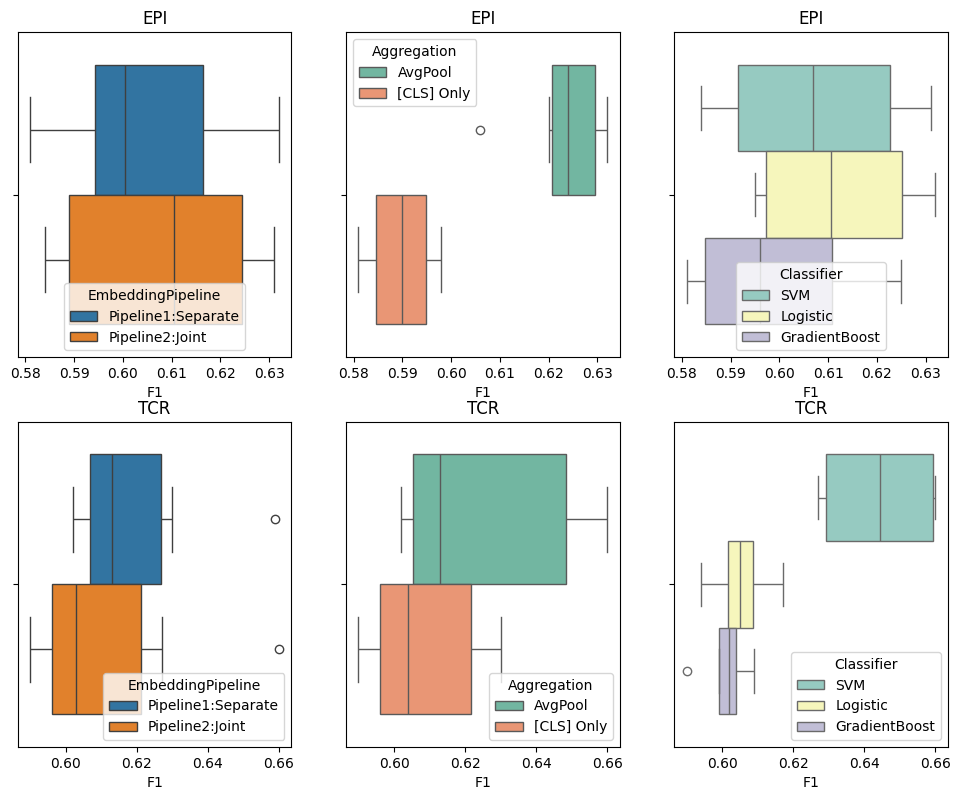

In [215]:
import seaborn as sns

epiresdf = epiresdf.replace('boost', 'GradientBoost')
epiresdf = epiresdf.replace('svm', 'SVM')
epiresdf = epiresdf.replace('full', 'AvgPool')
epiresdf = epiresdf.replace('pooled', '[CLS] Only')
epiresdf = epiresdf.replace('logistic', 'Logistic')
epiresdf = epiresdf.replace('joint', 'Pipeline2:Joint')
epiresdf = epiresdf.replace('separate', 'Pipeline1:Separate')

tcrresdf = tcrresdf.replace('boost', 'GradientBoost')
tcrresdf = tcrresdf.replace('svm', 'SVM')
tcrresdf = tcrresdf.replace('full', 'AvgPool')
tcrresdf = tcrresdf.replace('pooled', '[CLS] Only')
tcrresdf = tcrresdf.replace('logistic', 'Logistic')
tcrresdf = tcrresdf.replace('joint', 'Pipeline2:Joint')
tcrresdf = tcrresdf.replace('separate', 'Pipeline1:Separate')

import seaborn as sns
plt.figure(figsize=(4.8*2.5, 6.4*1.45))
plt.subplot(2, 3, 1)
sns.boxplot(data=epiresdf, x='F1', hue='EmbeddingPipeline', orient='v')
plt.title('EPI')
plt.subplot(2, 3, 2)
sns.boxplot(data=epiresdf, x='F1', hue='Aggregation', palette="Set2")
plt.title('EPI')

plt.subplot(2, 3, 3)
sns.boxplot(data=epiresdf, x='F1', hue='Classifier', palette="Set3")
plt.title('EPI')

plt.subplot(2, 3, 4)
sns.boxplot(data=tcrresdf, x='F1', hue='EmbeddingPipeline')
plt.title('TCR')
plt.subplot(2, 3, 5)
sns.boxplot(data=tcrresdf, x='F1', hue='Aggregation', palette="Set2")
plt.title('TCR')
plt.subplot(2, 3, 6)
sns.boxplot(data=tcrresdf, x='F1', hue='Classifier', palette="Set3", orient='vertical')
plt.title('TCR')
plt.savefig('./comparison.pdf', bbox_inches='tight')

# Perform Hyperparameter Sweep on joint (Warning this takes days to run)

In [ ]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def train_and_evaluate(X, y, model, param_grid=None):
    scores = []
    ii=0
    for train_index, test_index in tqdm.tqdm(kf.split(X)):
        print(f'Fold {ii}')
        ii+=1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Normalize 
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # PCA
        pca = PCA(n_components=50)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=3)
            grid_search.fit(X_train_pca, y_train)
            model = grid_search.best_estimator_
        else:
            model.fit(X_train_pca, y_train)

        score = model.score(X_test_pca, y_test)
        scores.append(score)

    return scores

# MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [.00001, 0.0001, 0.001, 0.01, .1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter':[200]
}
mlp_scores = train_and_evaluate(embs, labels, MLPClassifier(), mlp_param_grid)

# XGBoost
xgb_scores = train_and_evaluate(embs, labels, GradientBoostingClassifier())

# SVC
svc_param_grid = {
    'C': [1e-2, 0.1, 1, 10, 100, 1000, 10000],
    'gamma': [1e-4, 1e-3, 0.01, 0.1, 1]
}

dct = pkl.load(open('./embsbert/tcr_train_dct.pkl', 'rb'))
# dct_te = pkl.load(open('./embsbert/tcr_test_dct.pkl', 'rb'))
# dct_ho = pkl.load(open('./embsbert/tcr_holdout_dct.pkl', 'rb'))
labels = dfttr.Label.values

embs = dct['joint_full']
svc_scores = train_and_evaluate(embs, labels, SVC(), svc_param_grid)

# Plot the results
plt.boxplot([mlp_scores, xgb_scores, svc_scores], labels=['MLP', 'XGBoost', 'SVC'])
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison')
plt.show()

# Results of hyperparameter sweep (best classifier from each)
Classifier sweep was performed on the joint embeddings, full means average pooling was performed instead of using the CLS token embedding 

In [75]:
mlp_scores = [0.6819671145579703,
 0.670634562779932,
 0.6708449815132113,
 0.6708149216941715,
 0.673811098418806]
xgb_scores = [0.6311660203805574,
 0.6257853127724171,
 0.6258454324104968,
 0.6268374064388132,
 0.6265556423976433]
svr_scores = [0.6970270838969549,
 0.6947725974689632,
 0.6892716505846634,
 0.6924579914028918, 0.6976492514880057]

/tmp/ipykernel_262716/1067576198.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mlp_scores, xgb_scores, svr_scores], labels=['MLP', 'GradientBoosting', 'SVM'])


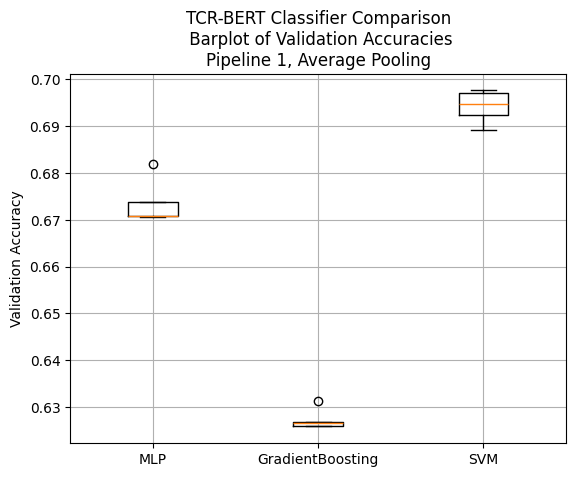

In [80]:
plt.figure()
plt.boxplot([mlp_scores, xgb_scores, svr_scores], labels=['MLP', 'GradientBoosting', 'SVM'])
plt.ylabel('Validation Accuracy')
plt.title('TCR-BERT Classifier Comparison\n Barplot of Validation Accuracies\nPipeline 1, Average Pooling')
plt.grid()
plt.savefig('./clf_perf.pdf', bbox_inches='tight')